# Импорт Библиотек

In [138]:
import pandas as pd

import numpy as np

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, ConcatDataset

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import albumentations as A
from albumentations.pytorch import ToTensorV2

%matplotlib inline

# Установим сиды для рандома

In [139]:
seed = 42

np.random.seed(seed)

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Установим устройство (CPU или GPU)

In [140]:
torch.cuda.is_available(), torch.backends.cudnn.enabled

(False, True)

In [141]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

# Импорт Данных

То, на чем будем учиться

In [142]:
train = pd.read_csv('train.csv')

In [143]:
print(train.shape)
train.head()

(42000, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


То, на чем будем сдавать в самом конце для kaggle

In [144]:
finaltest = pd.read_csv('test.csv')

In [145]:
print(finaltest.shape)
finaltest.head()

(28000, 784)


,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Пример того, как надо сдавать результаты

In [146]:
sample_submission = pd.read_csv('sample_submission.csv')

In [147]:
sample_submission.head()

,ImageId,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


# Анализ данных

Проверим сбалансированность классов

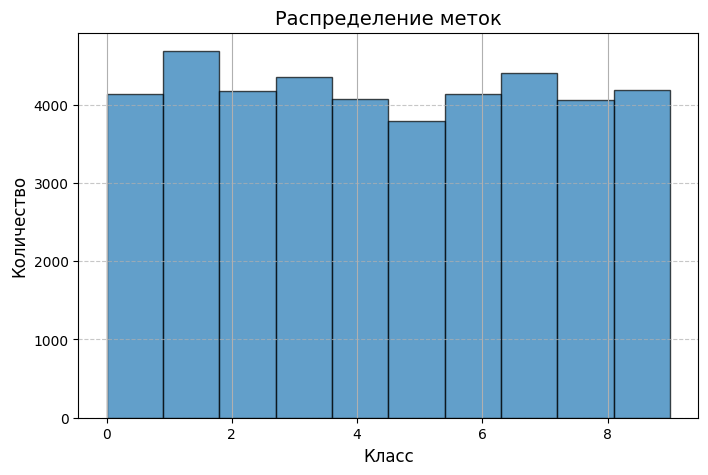

In [148]:
plt.figure(figsize=(8, 5))
train['label'].hist(
    bins=10,          # число столбцов
    edgecolor='black',# рамки вокруг баров
    alpha=0.7,        # прозрачность
)

plt.title("Распределение меток", fontsize=14)
plt.xlabel("Класс", fontsize=12)
plt.ylabel("Количество", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

# Подготовка Данных

Извлекаем отдельно признаки и отдельно целевые значения

In [149]:
features_np = train.iloc[:, 1:].values
targets_np = train.label.values

Производим нормировку признаков

In [150]:
features_norm_np = features_np / 255

In [151]:
# Проверка, что нормировка проведена успешно
features_norm_np.min(), features_norm_np.max()

(np.float64(0.0), np.float64(1.0))

Разделяем данные для обучения и для тестирования

In [152]:
test_size = 0.3
stratify = targets_np

features_train, features_test, targets_train, targets_test = train_test_split(
    features_norm_np,
    targets_np,
    test_size=test_size,
    stratify=stratify,
    random_state=seed
)

Проверяем, что разделилось все правильно

In [153]:
# 42_000 * 0.7 = 29_400
features_train.shape, targets_train.shape

((29400, 784), (29400,))

In [154]:
# 42_000 - 29_400 = 12_600
features_test.shape, targets_test.shape

((12600, 784), (12600,))

Подгоним размерности для сверточных слоев

In [155]:
features_train = features_train.reshape(features_train.shape[0], 1, 28, 28)
features_test = features_test.reshape(features_test.shape[0], 1, 28, 28)

Переводим в тензоры

In [156]:
features_train_tn = torch.from_numpy(features_train).float()
targets_train_tn = torch.from_numpy(targets_train).long()

features_test_tn = torch.from_numpy(features_test).float()
targets_test_tn = torch.from_numpy(targets_test).long()

Проверяем, что все перевелось правильно

In [157]:
type(features_train_tn), type(targets_train_tn), type(features_test_tn), type(targets_test_tn)

(torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor)

Создаем Датасеты и Даталоудеры, проводим аугментацию данных

In [158]:
class DigitDataset(Dataset):
    def __init__(self, features, targets, augmentations=None):
        self.features = features
        self.targets = targets
        self.augmentations = augmentations
        
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        image = self.features[idx]
        
        if isinstance(image, torch.Tensor):
            image = image.detach().cpu().numpy()
        
        # to H×W×C
        if image.ndim == 2:
            image = image[..., None]
        elif image.ndim == 3 and image.shape[0] == 1:  # C×H×W -> H×W×C
            image = np.transpose(image, (1, 2, 0))
        
        # uint8 for CLAHE/OpenCV
        if image.dtype != np.uint8:
            image = (image * 255.0).clip(0, 255).astype(np.uint8)
        
        target = self.targets[idx]
        
        if self.augmentations:
            augmented = self.augmentations(image=image)
            return augmented['image'], target
        else:
            return image, target
        
class DigitInferenceDataset(Dataset):
    def __init__(self, features, augmentations=None):
        self.features = features
        self.augmentations = augmentations
        
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        image = self.features[idx]
        
        if isinstance(image, torch.Tensor):
            image = image.detach().cpu().numpy()
        
        # to H×W×C
        if image.ndim == 2:
            image = image[..., None]
        elif image.ndim == 3 and image.shape[0] == 1:  # C×H×W -> H×W×C
            image = np.transpose(image, (1, 2, 0))
        
        # uint8 for CLAHE/OpenCV
        if image.dtype != np.uint8:
            image = (image * 255.0).clip(0, 255).astype(np.uint8)
        
        if self.augmentations:
            augmented = self.augmentations(image=image)
            return augmented['image']
        else:
            return image

In [159]:
PROB = 0.7
IMG_H, IMG_W = 28, 28

transform_train = A.Compose(
    [
        # Геометрия через Affine
        A.Affine(
            scale=(0.9, 1.1),      # от -10% до +10%
            translate_percent=(0.05, 0.05),  # сдвиги ±5%
            rotate=(-15, 15),      # поворот ±15°
            fit_output=False,      # оставляем размер 28×28
            p=PROB
        ),

        # Лёгкое ухудшение качества
        A.Downscale(scale_range=(0.9, 0.95), p=0.25),

        # Аккуратная локальная контрастность
        A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=0.20),

        # Нормализация под MNIST
        A.Normalize(mean=(0.1307,), std=(0.3081,), max_pixel_value=255.0, p=1.0),
        ToTensorV2(),
    ]
)

transform_valid = A.Compose(
    [
        A.Normalize(mean=(0.1307,), std=(0.3081,), max_pixel_value=255.0, p=1.0),
        ToTensorV2(),
    ]
)


In [160]:
# Оригиналы + аугментированные
train_ds_orig = DigitDataset(features_train_tn, targets_train_tn, augmentations=transform_valid)
train_ds_aug  = DigitDataset(features_train_tn, targets_train_tn, augmentations=transform_train)  
train_ds = ConcatDataset([train_ds_orig, train_ds_aug])

test_ds = DigitDataset(features_test_tn, targets_test_tn, augmentations=transform_valid)

In [161]:
batch_size = 64
num_workers = 0

train_loader = DataLoader(
    train_ds,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=True,
    drop_last=True,
    pin_memory=(device.type=='cuda')
)
test_loader = DataLoader(
    test_ds,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=True,
    pin_memory=(device.type=='cuda')
)

Проверяем, что все создалось правильно

In [162]:
train_ds, test_ds

(<torch.utils.data.dataset.ConcatDataset at 0x20d484a4590>,
 <__main__.DigitDataset at 0x20d488ec710>)

In [163]:
train_loader, test_loader 

(<torch.utils.data.dataloader.DataLoader at 0x20d335a5cd0>,
 <torch.utils.data.dataloader.DataLoader at 0x20d4892c500>)

# Создаем Сам Классификатор

In [164]:
class DigitClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        # Компоненты классификатора
        self.conv_block = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2) 
        )
        
        self.linear_block = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(128*7*7, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(64, 10)
        )
        
    def forward(self, x):
        x = self.conv_block(x)
        x = x.view(x.size(0), -1)
        x = self.linear_block(x)
        
        return x

# Обучение

Подготовка

In [165]:
model = DigitClassifier()

loss_function = nn.CrossEntropyLoss()

learning_rate = 0.001
weight_decay = 1e-4
optimizer = optim.Adam(
    params=model.parameters(),
    lr=learning_rate,
    weight_decay=weight_decay
)

exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

epochs = 25

Переведем все, что можно нужное устройство

In [166]:
if device.type == 'cuda':
    model.cuda()
    loss_function.cuda()

Главный цикл обучения

In [167]:
model.train()
for epoch in range(epochs):
    i = 0
    for images, labels in train_loader:
        print(f'Эпоха: {epoch}; Итерация: {i}')
        i += 1

        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        
        logits_ps = model(images)
        loss = loss_function(logits_ps, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    exp_lr_scheduler.step()

Эпоха: 0; Итерация: 0
Эпоха: 0; Итерация: 1
Эпоха: 0; Итерация: 2
Эпоха: 0; Итерация: 3
Эпоха: 0; Итерация: 4
Эпоха: 0; Итерация: 5
Эпоха: 0; Итерация: 6
Эпоха: 0; Итерация: 7
Эпоха: 0; Итерация: 8
Эпоха: 0; Итерация: 9
Эпоха: 0; Итерация: 10
Эпоха: 0; Итерация: 11
Эпоха: 0; Итерация: 12
Эпоха: 0; Итерация: 13
Эпоха: 0; Итерация: 14
Эпоха: 0; Итерация: 15
Эпоха: 0; Итерация: 16
Эпоха: 0; Итерация: 17
Эпоха: 0; Итерация: 18
Эпоха: 0; Итерация: 19
Эпоха: 0; Итерация: 20
Эпоха: 0; Итерация: 21
Эпоха: 0; Итерация: 22
Эпоха: 0; Итерация: 23
Эпоха: 0; Итерация: 24
Эпоха: 0; Итерация: 25
Эпоха: 0; Итерация: 26
Эпоха: 0; Итерация: 27
Эпоха: 0; Итерация: 28
Эпоха: 0; Итерация: 29
Эпоха: 0; Итерация: 30
Эпоха: 0; Итерация: 31
Эпоха: 0; Итерация: 32
Эпоха: 0; Итерация: 33
Эпоха: 0; Итерация: 34
Эпоха: 0; Итерация: 35
Эпоха: 0; Итерация: 36
Эпоха: 0; Итерация: 37
Эпоха: 0; Итерация: 38
Эпоха: 0; Итерация: 39
Эпоха: 0; Итерация: 40
Эпоха: 0; Итерация: 41
Эпоха: 0; Итерация: 42
Эпоха: 0; Итерация: 4

Валидация

In [168]:
correct = 0
test_size = len(test_loader.dataset)

with torch.no_grad():
    model.eval()
    for images, labels in test_loader:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        
        logits_ps = model(images)
        loss = loss_function(logits_ps, labels)

        predictions = torch.argmax(logits_ps, dim=1)

        correct += (predictions == labels).sum().item()

Получившаяся точность

In [169]:
accuracy = correct / test_size
print(f'Test Accuracy: {accuracy * 100:.2f}')

Test Accuracy: 98.94


# Подготовка Данных Для Сдачи

Переводим в пандас

In [170]:
finaltest_np = finaltest.values
type(finaltest_np)

numpy.ndarray

Нормируем

In [171]:
mean, std = 0.1307, 0.3081
finaltest_norm_np = (finaltest_np.astype(np.float32) / 255.0 - mean) / std

Проверяем

In [172]:
finaltest_norm_np.min(), finaltest_norm_np.max()

(np.float32(-0.42421296), np.float32(2.8214867))

In [173]:
finaltest_norm_np.shape

(28000, 784)

Подгоняем размерности под сверточные слои

In [174]:
finaltest_norm_np = finaltest_norm_np.reshape(finaltest_norm_np.shape[0], 1, 28, 28)

Проверяем

In [175]:
finaltest_norm_np.shape

(28000, 1, 28, 28)

Переводим в тензор

In [176]:
finaltest_tn = torch.from_numpy(finaltest_norm_np).float()

Проверяем

In [177]:
type(finaltest_tn)

torch.Tensor

Производим прогнозирование на финальных данных

In [178]:
labels = []

model.eval()
with torch.no_grad():
    for data in finaltest_tn:
        data = data.to(device, non_blocking=True)
        
        logits_ps = model(data.unsqueeze(1))
        
        prediction = torch.argmax(logits_ps).item()
        
        labels.append(prediction)

Сохраняем метки для сдачи в соответствующий датафрейм

In [179]:
sample_submission['Label'] = labels

Проверка, что все занеслось правильно

In [180]:
sample_submission.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3


Запись в файл для сдачи

In [181]:
sample_submission.to_csv('submission.csv', index=False)

Проверяем, что файл записался

In [182]:
result = pd.read_csv('submission.csv')
print(result.shape)
result.head()

(28000, 2)


,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3
